# CONET test
> compare conet with victree result

## Read simulated data

In [15]:
import scgenome.plotting as pl
import anndata
import pandas as pd

In [62]:
adata = anndata.read_h5ad("/Users/zemp/PycharmProjects/victree/datasets/simul_k5a7n300m413e1-50d10mt1-100-5000-500.h5ad")

/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [63]:
adata.layers

Layers with keys: copy, victree-cn-marginal

{'fig': <Figure size 640x480 with 5 Axes>,
 'axes': array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='chromosome'>, <Axes: >]], dtype=object),
 'adata': View of AnnData object with n_obs × n_vars = 300 × 413
     obs: 'victree-clone'
     var: 'chr', 'start', 'end'
     layers: 'copy', 'victree-cn-marginal',
 'im': <matplotlib.image.AxesImage at 0x293beffa0>,
 'legend_info': {'ax_legend': <Axes: >,
  'legend': <matplotlib.legend.Legend at 0x293fd5360>},
 'annotation_info': {}}

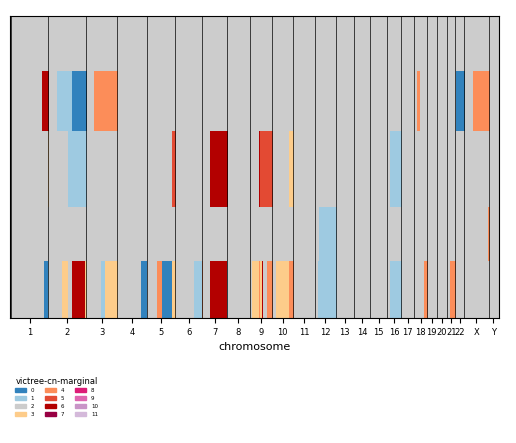

In [64]:
pl.plot_cell_cn_matrix_fig(adata, 'victree-cn-marginal', cell_order_fields=['victree-clone'], max_cn=7)

## Candidate breakpoints

**ground truth candidate**

In [65]:
# create dataframe chr, start, end, c1, c2, ..., cN
adata.obs_names = pd.Series(['c' + str(i).zfill(4) for i in range(adata.n_obs)])
obs_df = adata.to_df(layer='copy').transpose()

In [66]:
# create dataframe chr, start, end, cn1, cn2, cnK
# to then transform into candidate_brkpt
clone_cn = adata.to_df(layer='victree-cn-marginal').drop_duplicates().transpose()
for c in clone_cn.columns:
    clone_cn[c] = (clone_cn[c].diff() != 0).astype(int)

clone_cn.head()

,c0000,c0001,c0002,c0004,c0006
0,1,1,1,1,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [67]:
candidate_breakpoints_df = pd.concat([adata.var[['chr', 'start', 'end']], 
                                      clone_cn.prod(axis=1).rename('candidate_brkp')], axis=1)
conet_df = pd.concat([candidate_breakpoints_df, obs_df], axis=1)
conet_df.head()

,chr,start,end,candidate_brkp,c0000,c0001,c0002,c0003,c0004,c0005,c0006,c0007,c0008,c0009,c0010,c0011,c0012,c0013,c0014,c0015,c0016,c0017,c0018,c0019,c0020,c0021,c0022,c0023,c0024,c0025,c0026,c0027,c0028,c0029,c0030,c0031,c0032,c0033,c0034,c0035,...,c0260,c0261,c0262,c0263,c0264,c0265,c0266,c0267,c0268,c0269,c0270,c0271,c0272,c0273,c0274,c0275,c0276,c0277,c0278,c0279,c0280,c0281,c0282,c0283,c0284,c0285,c0286,c0287,c0288,c0289,c0290,c0291,c0292,c0293,c0294,c0295,c0296,c0297,c0298,c0299
0,1,0,7749336,1,1.437431,1.560294,1.884278,1.929246,1.633840,1.942915,2.495543,2.025960,2.125158,2.144950,1.592657,1.648314,1.894342,2.608523,2.460575,2.018207,2.653108,1.512030,1.860015,2.070990,1.641192,2.554295,2.299476,2.363364,2.350515,2.031500,2.256466,1.934800,2.275164,1.808516,1.646904,2.357411,2.071434,1.374103,2.808280,1.488310,...,1.837641,1.924797,2.274069,2.734943,2.236623,1.952705,2.267344,1.774222,1.945548,2.157336,2.131583,1.979826,1.889763,2.058184,2.003356,2.083765,2.115124,2.208945,2.102989,2.057575,1.608944,2.515030,2.179735,1.560844,1.488297,2.073373,1.788569,1.635754,2.286317,1.974094,1.528183,2.094200,1.709756,2.004851,2.578769,1.690793,2.126770,1.747978,2.272611,2.109701
1,1,7749336,15498672,0,2.140516,1.737734,2.427720,1.558800,2.466780,1.912031,1.981976,2.241083,2.127721,1.400651,2.637193,2.248323,2.007531,2.121629,2.463126,1.785123,1.966999,1.684052,2.573258,1.906262,2.293266,2.787999,2.038072,2.005635,1.643228,1.926967,2.195616,1.814709,1.782812,1.698390,2.347162,1.889240,2.577488,2.074394,2.470609,1.960603,...,1.865622,1.901597,1.762826,2.191623,1.672995,1.834380,2.096921,1.712838,2.067236,1.968576,2.115674,2.742478,2.320042,2.141785,1.595565,1.816585,2.089346,2.176316,1.672161,2.445966,1.620884,1.739127,2.051282,2.158057,2.217809,1.761959,1.834700,2.177034,2.046910,2.477594,2.086839,2.193785,1.609355,2.841668,2.614898,1.740510,2.327259,2.226901,2.599956,2.101210
2,1,15498672,23248008,0,1.920866,1.760116,2.427131,1.640353,2.304060,2.218070,1.720212,2.169319,1.922060,2.182901,2.142421,1.855558,1.267055,2.268798,1.800212,2.352908,1.847846,1.660135,2.458450,1.925789,1.609024,1.766368,1.971058,2.187675,2.446626,2.104055,2.635453,1.974700,2.730491,2.285250,1.924712,2.168139,1.683735,2.041549,1.950377,2.772969,...,1.682235,2.279844,1.910457,2.245847,2.372932,1.549587,1.934763,1.667130,1.825361,2.190851,1.873653,1.674323,1.778558,1.853010,1.840326,2.029975,1.896235,1.927093,2.048989,2.261884,1.923274,1.697208,1.703176,2.160739,1.998943,1.965616,1.965400,1.762174,1.911007,1.577535,2.214684,2.126472,2.095701,2.265936,1.997960,1.886599,2.268117,2.109402,2.512913,1.646358
3,1,23248008,30997344,0,1.458292,1.855133,1.975354,1.849105,2.171490,2.055892,2.120776,2.249464,2.095241,2.174714,2.096476,1.491417,2.140066,1.245421,1.814499,2.328321,2.256404,1.914168,1.200819,2.141337,1.784483,2.012822,1.836042,2.208965,2.025174,1.805675,1.934343,1.967851,2.691108,2.081453,2.668181,1.605932,2.268224,1.954441,2.106804,2.563787,...,2.283455,1.497105,2.107411,2.590089,2.455244,2.043369,1.823470,1.920401,1.910738,2.136718,2.063474,2.317641,2.869334,1.826953,1.850012,2.006582,1.808010,2.185215,2.416670,1.883082,1.865996,1.711400,2.057554,1.760030,2.175313,2.444900,2.177073,1.987139,2.150816,2.513173,2.379194,1.328647,1.314626,2.215953,2.141236,1.780622,2.266459,1.911564,1.962860,1.384462
4,1,30997344,38746680,0,1.997892,2.040846,1.713215,2.424013,1.898444,1.780749,1.582054,1.993452,2.143148,1.841058,2.369241,2.296145,1.547977,1.854530,2.438025,1.863597,2.100226,2.449472,1.854483,1.804381,2.025429,1.715136,2.166880,2.120797,1.544742,1.965938,2.454777,2.077994,1.386554,2.015552,1.637877,2.126772,2.007757,1.990439,2.156564,2.163059,...,2.176434,1.986435,2.043137,2.277541,1.809433,1.243447,2.026639,1.842154,1.722288,2.031078,1.767547,2.484655,1.998147,2.018631,2.180590,1.614054,1.965200,1.828275,2.085262,1.870811,2.236118,1.716175,2.074340,1.718437,1.347124,0.970948,2.312664,1.340768,1.948014,1.874671,1.581874,1.859900,2.008312,1.702983,2.341468,1.39

**HMMcopy pre-processing**

## Run CONET

In [71]:
bin_dir = "/Users/zemp/phd/scilife/cpt_experiments/CONET/CONET"
from conet import CorrectedCounts, DataConverter

cc = CorrectedCounts(conet_df)
DataConverter(event_length_normalizer=3095677412).create_CoNET_input_files(bin_dir, corrected_counts=cc)

## Load VICTREE output

## Compare with ARI score